In [ ]:
DIR = 'gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/'

# GAN with PINN (implemented hemodynamics laws and cardiovascular graph).
* MRI image 3000х300.
* Healthy patients real, Sick - generated.
* Two model output.
* Binary cross-entropy loss function together with loss residuals.

# Libraries imports


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Download dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = np.load("gdrive/MyDrive/Colab_Notebooks/Images/small_data.npy")
labels = np.genfromtxt('gdrive/MyDrive/Colab_Notebooks/Images/all_target.csv', delimiter=',')
labels = labels[1:].astype(int)

In [ ]:
print(data.shape)
print(labels.shape)
print(labels)

(81, 10, 512, 512)
(81,)
[1 6 2 2 1 2 1 1 0 2 1 0 1 3 2 3 2 3 4 1 2 4 4 1 1 1 1 4 2 4 2 1 2 1 5 1 1
 3 6 2 1 3 4 1 1 1 2 1 1 1 1 1 2 5 1 3 2 3 4 6 1 1 1 2 3 1 2 1 1 2 2 2 2 2
 2 6 2 2 2 2 3]


In [ ]:
for i in range(10):
  plt.imshow(data[0][i])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Data preprocessing


In [ ]:
labels = np.array([1 if i < 3 else 0 for i in labels]) #1 - healthy | 0 - sick
print(labels)

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1
 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0]


In [ ]:
dataSingle = data.reshape(data.shape[0], 5120, 512).astype('float32') # Merge 10 images into one
for i in range(data.shape[0]):
  dataSingle[i] = dataSingle[i]/dataSingle[i].max()

In [ ]:
data = data.astype('float32')
for i in range(data.shape[0]):
  for j in range(10):
    data[i][j] = data[i][j]/data[i][j].max()

<ipython-input-10-ff873b7ffa6c>:4: RuntimeWarning: invalid value encountered in true_divide
  data[i][j] = data[i][j]/data[i][j].max()


In [ ]:
test_dataSingle = dataSingle[:21]
test_data = data[:21]
test_labels = labels[:21]
test_labels = test_labels.reshape(21,1)

data = data[21:]
dataSingle = dataSingle[21:]
labels = labels[21:]
labels = labels.reshape(60,1)

print(test_dataSingle.shape)
print(test_data.shape)
print(test_labels.shape)
print(dataSingle.shape)
print(data.shape)
print(labels.shape)

(21, 5120, 512)
(21, 10, 512, 512)
(21, 1)
(60, 5120, 512)
(60, 10, 512, 512)
(60, 1)


# Generate images


## Data preprocessing


In [ ]:
data = np.load("gdrive/MyDrive/Colab_Notebooks/Images/small_data.npy")
labels = np.genfromtxt('gdrive/MyDrive/Colab_Notebooks/Images/all_target.csv', delimiter=',')
labels = labels[1:].astype(int)

In [ ]:
print(data.shape)
print(labels.shape)
print(labels)

(81, 10, 512, 512)
(81,)
[1 6 2 2 1 2 1 1 0 2 1 0 1 3 2 3 2 3 4 1 2 4 4 1 1 1 1 4 2 4 2 1 2 1 5 1 1
 3 6 2 1 3 4 1 1 1 2 1 1 1 1 1 2 5 1 3 2 3 4 6 1 1 1 2 3 1 2 1 1 2 2 2 2 2
 2 6 2 2 2 2 3]


In [ ]:
dataPINN = [0]*81
for i in range(81):
  dataPINN[i] = [0]*10

In [ ]:
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    dataPINN[i][j] = data[i][j][130:430, 100:400]

In [ ]:
for i in range(10):
  plt.imshow(dataPINN[0][i])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
labels = np.array([1 if i < 3 else 0 for i in labels]) #1 - healthy | 0 - sick
print(labels)

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1
 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0]


In [ ]:
dataPINN = np.asarray(dataPINN)

In [ ]:
dataPINN = dataPINN.reshape(dataPINN.shape[0], 3000, 300).astype('float32') # Merge 10 images into one
for i in range(dataPINN.shape[0]):
  dataPINN[i] = dataPINN[i]/dataPINN[i].max()

In [ ]:
print(dataPINN.shape)

(81, 3000, 300)


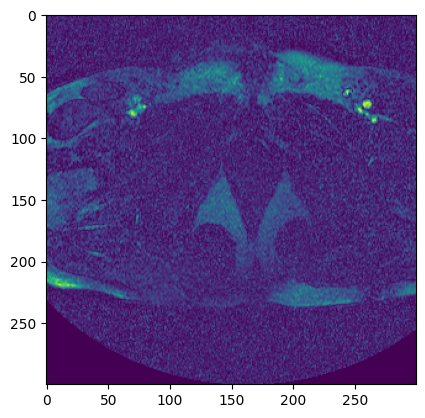

In [ ]:
plt.imshow(dataPINN[0].reshape(10,300,300)[0])
plt.show()

In [ ]:
test_dataPINN = dataPINN[:21]
test_labels = labels[:21]
test_labels = test_labels.reshape(21,1)

dataPINN = dataPINN[21:]
labels = labels[21:]
labels = labels.reshape(60,1)

print(test_dataPINN.shape)
print(test_labels.shape)
print(dataPINN.shape)
print(labels.shape)

(21, 3000, 300)
(21, 1)
(60, 3000, 300)
(60, 1)


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 3
RANDOM_SEED = 42

my_labels = tf.data.Dataset.from_tensor_slices([i for i in range(60)])
my_labels = my_labels.shuffle(1000, seed = RANDOM_SEED)
my_labels = my_labels.batch(BATCH_SIZE)

for i in my_labels:
  print(i.tolist(), end = '\t[')
  print(labels[i.tolist()[0]], end = ', ')
  print(labels[i.tolist()[1]], end = ', ')
  print(labels[i.tolist()[2]], end = '] ')
  print()

[45, 42, 56]	[[1], [1], [1]] 
[52, 5, 59]	[[1], [1], [0]] 
[14, 24, 7]	[[1], [1], [1]] 
[15, 16, 36]	[[1], [0], [0]] 
[13, 17, 53]	[[0], [0], [1]] 
[43, 51, 55]	[[0], [1], [1]] 
[41, 34, 40]	[[1], [0], [1]] 
[22, 46, 39]	[[1], [1], [1]] 
[8, 6, 19]	[[0], [0], [1]] 
[2, 9, 21]	[[1], [1], [0]] 
[50, 23, 4]	[[1], [1], [1]] 
[38, 28, 54]	[[0], [1], [0]] 
[20, 11, 29]	[[0], [1], [1]] 
[3, 27, 47]	[[1], [1], [1]] 
[26, 33, 31]	[[1], [1], [1]] 
[44, 58, 48]	[[1], [1], [1]] 
[25, 18, 0]	[[1], [1], [0]] 
[35, 10, 37]	[[1], [1], [0]] 
[57, 49, 32]	[[1], [1], [0]] 
[12, 30, 1]	[[1], [1], [0]] 


In [ ]:
my_labels = tf.data.Dataset.from_tensor_slices([i for i in range(60)])
my_labels = my_labels.shuffle(1000, seed = RANDOM_SEED)
my_labels = my_labels.batch(BATCH_SIZE)

train_dataset_pinn = tf.data.Dataset.from_tensor_slices(dataPINN);
train_labels = tf.data.Dataset.from_tensor_slices(labels);

train_dataset_pinn = train_dataset_pinn.shuffle(BUFFER_SIZE, seed = RANDOM_SEED)
train_dataset_pinn = train_dataset_pinn.batch(BATCH_SIZE)
train_labels = train_labels.shuffle(BUFFER_SIZE, seed = RANDOM_SEED)
train_labels = train_labels.batch(BATCH_SIZE)

## Модель

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(Dense(27, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(16*3, use_bias=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(150*15*3, use_bias=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((150, 15, 3)))
    assert model.output_shape == (None, 150, 15, 3) # Note: None is the batch size

    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 150, 15, 3)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 300, 30, 3)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(2, (5, 5), strides=(5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 1500, 150, 2)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 3000, 300, 1)

    return model

In [ ]:
noise_input = keras.Input(shape=(100,), name="noise")

dense = layers.Dense(27, use_bias=False)(noise_input)
dense = layers.BatchNormalization()(dense)
dense = layers.LeakyReLU()(dense)

param = layers.Dense(50, use_bias=True)(dense) #layers.LeakyReLU(name='Parameters_of_CV')(param)
param = layers.BatchNormalization()(param)
param = layers.Activation(activation='relu', name='Parameters_of_CV')(param)

dense2 = layers.Dense(150*15*3, use_bias=True)(param)
dense2 = layers.BatchNormalization()(dense2)
dense2 = layers.LeakyReLU()(dense2)

dense2 = layers.Reshape((150, 15, 3))(dense2)

conv1 = layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False)(dense2)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.LeakyReLU()(conv1)

conv2 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.LeakyReLU()(conv2)

conv3 = layers.Conv2DTranspose(2, (5, 5), strides=(5, 5), padding='same', use_bias=False)(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.LeakyReLU()(conv3)

image_pred = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', name='Images')(conv3)
#conv4 = layers.BatchNormalization()(conv4)
#conv4 = layers.LeakyReLU()(conv4)

generator = keras.Model(
    inputs=[noise_input],
    outputs=[param, image_pred],
)

In [ ]:
#generator = make_generator_model()

In [ ]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 27)                2700      
                                                                 
 batch_normalization (BatchN  (None, 27)               108       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                1400      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                             

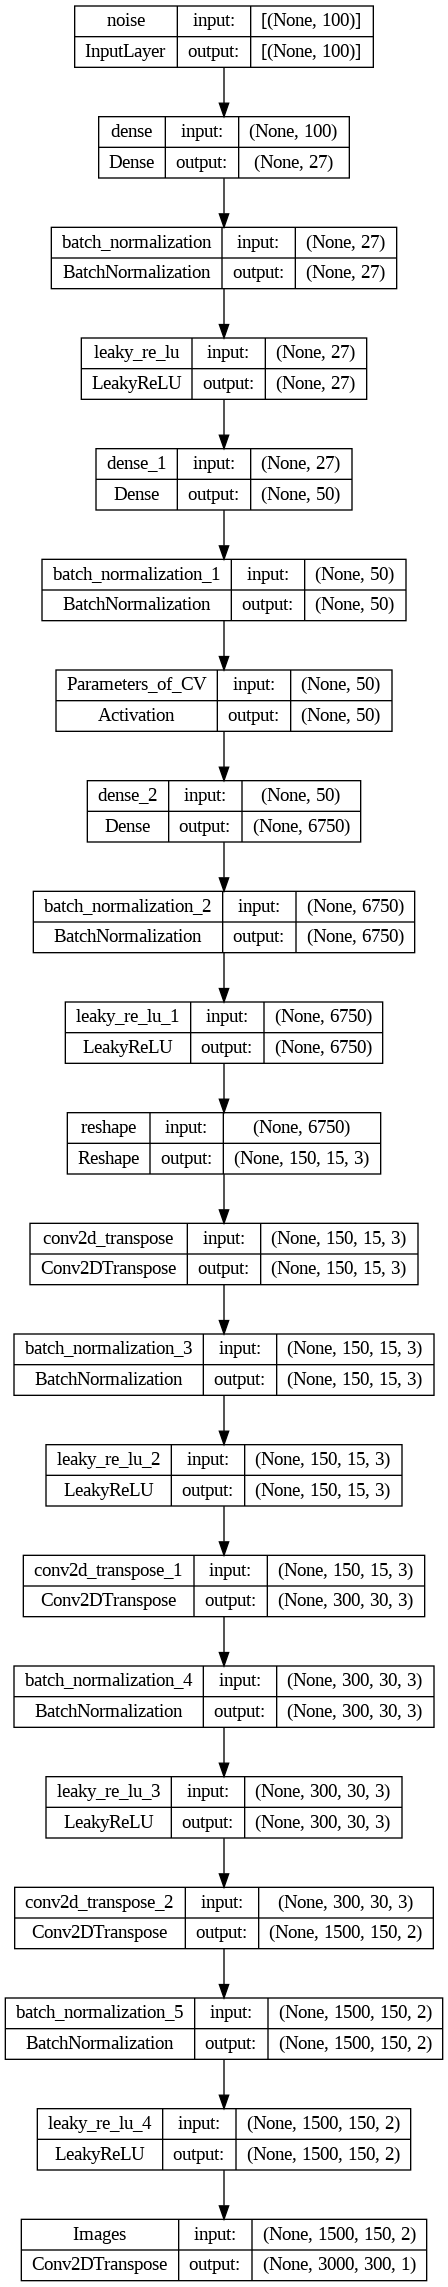

In [ ]:
keras.utils.plot_model(generator, "generator_model.png", show_shapes=True)

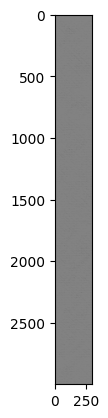

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)[1]
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
generated_image.shape

TensorShape([1, 3000, 300, 1])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[3000, 300, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(1, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(27))
    model.add(LeakyReLU())

    model.add(Flatten())
    model.add(Dense(48))
    model.add(LeakyReLU())

    model.add(Flatten())
    model.add(Dense(10))
    model.add(LeakyReLU())

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
image_input = keras.Input(shape=(3000, 300, 1), name="MRI")

conv_disc_1 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(image_input)
conv_disc_1 = layers.LeakyReLU()(conv_disc_1)
conv_disc_1 = layers.Dropout(0.3)(conv_disc_1)

conv_disc_2 = layers.Conv2D(1, (5, 5), strides=(2, 2), padding='same')(conv_disc_1)
conv_disc_2 = layers.LeakyReLU()(conv_disc_2)
conv_disc_2 = layers.Dropout(0.3)(conv_disc_2)


dense_disc_1 = layers.Flatten()(conv_disc_2)
dense_disc_1 = layers.Dense(27)(dense_disc_1)
#param_disc = layers.BatchNormalization()(dense)
dense_disc_1 = layers.LeakyReLU()(dense_disc_1)

param_disc = layers.Flatten()(dense_disc_1)
param_disc = layers.Dense(50)(param_disc)
param_disc = layers.Activation(activation='relu', name='Parameters__Of_CV')(param_disc) #layers.LeakyReLU(name='Parameters__Of_CV')(param_disc) #sigmoid

dense_disc_2 = layers.Flatten()(param_disc)
dense_disc_2 = layers.Dense(10)(dense_disc_2)
dense_disc_2 = layers.LeakyReLU()(dense_disc_2)

diagnosis_output = layers.Flatten()(dense_disc_2)
diagnosis_output = layers.Dense(1)(diagnosis_output)
diagnosis_output = layers.LeakyReLU(name='Diagnosis')(diagnosis_output)


discriminator = keras.Model(
    inputs=[image_input],
    outputs=[param_disc, diagnosis_output],
)

In [ ]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MRI (InputLayer)            [(None, 3000, 300, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1500, 150, 128)    3328      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1500, 150, 128)    0         
                                                                 
 dropout (Dropout)           (None, 1500, 150, 128)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, 750, 75, 1)        3201      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 750, 75, 1)        0         
                                                                 
 dropout_1 (Dropout)         (None, 750, 75, 1)        0   

In [ ]:
decision = discriminator(generated_image)
print(decision)

[<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[2.2252515e-04, 4.2084685e-07, 9.9168057e-05, 0.0000000e+00,
        1.0297619e-05, 0.0000000e+00, 0.0000000e+00, 5.0571274e-05,
        1.2970097e-04, 2.4849657e-04, 0.0000000e+00, 1.1345561e-04,
        8.8085413e-05, 1.2006238e-04, 0.0000000e+00, 9.4578441e-05,
        2.3468881e-05, 0.0000000e+00, 2.3908485e-04, 2.6735885e-04,
        0.0000000e+00, 2.4093089e-04, 1.6720445e-04, 2.0627791e-04,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.5229818e-05,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.9046626e-04, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.6326728e-05, 1.4053413e-04, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.3244369e-04, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.3637140e-04, 1.4053116e-04,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.2638913e-05]], dtyp

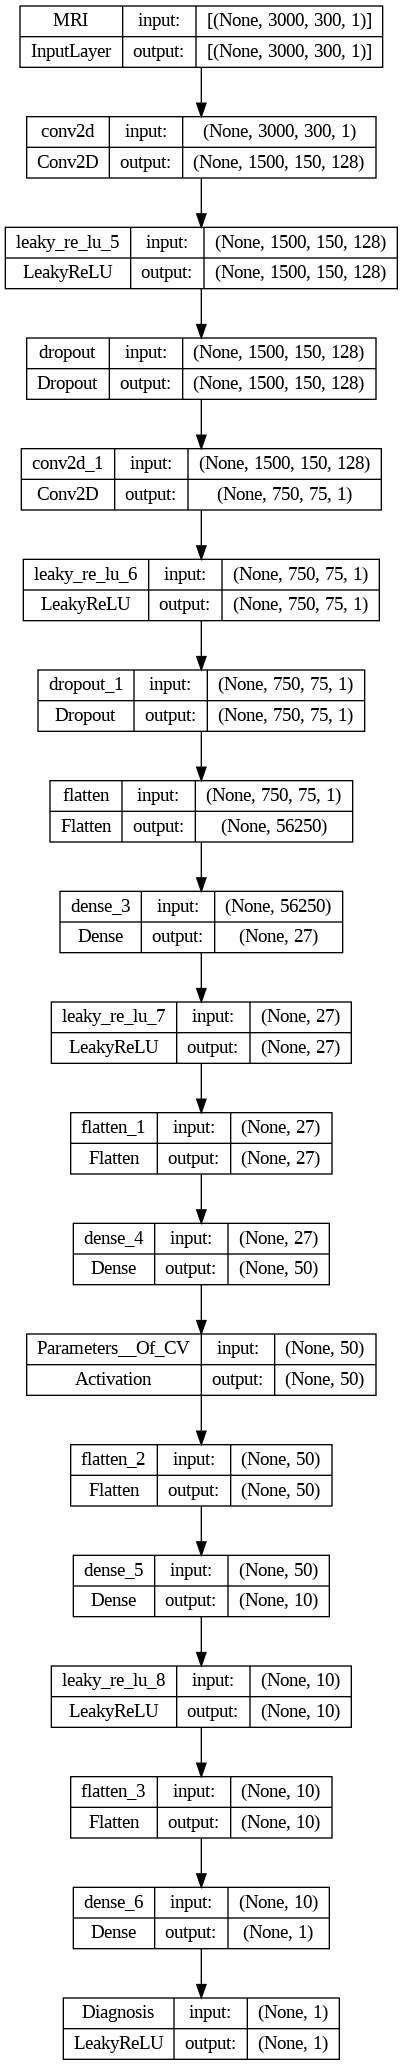

In [ ]:
keras.utils.plot_model(discriminator, "discriminator_model.png", show_shapes=True)

In [ ]:
S1 = [[1, 2, 0],
 [3, 4, 1],
 [5, 6, 2],
 [4, 6, 7],
 [9, 10, 8],
 [10, 11, 13],
 [12, 9, 14],
 [14, 13, 15]]

In [ ]:
S2 = [[0, 15], [12, 3], [11, 5], [7, 8]]

0 = 15
1 + 2 = 0
3 + 4 = 1
5 + 6 = 2
12 = 3
4 + 6 = 7
11 = 5
7 = 8
9 + 10 = 8
10 + 11 = 13
12 + 9 = 14
14 + 13 = 15

0 = 1
0 = 2
0 = 15
1 = 3
1 = 4
2 = 5
2 = 6
7 = 4
7 = 6
7 = 8
5 = 11
13 = 10
13 = 11
13 = 15
14 = 15
14 = 12
14 = 9
8 = 9
8 = 10
12 = 3


In [ ]:
from tensorflow.python.ops.gen_math_ops import sigmoid
# This method returns a helper function to compute cross entropy loss
from tensorflow.keras import backend as K

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

mse = tf.keras.losses.MeanSquaredError()


def loss_CV(real_output, fake_output):
  total_loss = [0]*real_output.shape[0]
  for j in range(real_output.shape[0]):
    total_loss[j] = [0]*(len(S1)*3+len(S2)*2)
    #print('SHAPE:', len(total_loss), real_output.shape, real_output.shape[0])
    for i in range(len(S2)):
      #print(i, total_loss, S2[i], real_output)
      A1,u1,p1 = real_output[j][S2[i][0]*3], real_output[j][S2[i][0]*3+1], real_output[j][S2[i][0]*3+2]
      A2,u2,p2 = real_output[j][S2[i][1]*3], real_output[j][S2[i][1]*3+1], real_output[j][S2[i][1]*3+2]
      total_loss[j][i*2] = A1*u1 - A2*u2
      if i == 0: # Heart
        total_loss[j][i*2+1] = p1 - p2 - real_output[j][-2] + 0.5*0.105*(u1**2-u2**2)
      else:      # Cap
        total_loss[j][i*2+1] = p1 - p2 - real_output[j][-1] + 0.5*0.105*(u1**2-u2**2)

    for i in range(len(S1)):
      A1,u1,p1 = real_output[j][S1[i][0]*3], real_output[j][S1[i][0]*3+1], real_output[j][S1[i][0]*3+2]
      A2,u2,p2 = real_output[j][S1[i][1]*3], real_output[j][S1[i][1]*3+1], real_output[j][S1[i][1]*3+2]
      A3,u3,p3 = real_output[j][S1[i][2]*3], real_output[j][S1[i][2]*3+1], real_output[j][S1[i][2]*3+2]
      total_loss[j][8+i*3] = A3*u3 - A2*u2 - A1*u1
      total_loss[j][8+i*3+1] = p3 - p1 + 0.5*0.105*(u3**2-u1**2)
      total_loss[j][8+i*3+2] = p3 - p2 + 0.5*0.105*(u3**2-u2**2)
    #print(total_loss)
  answer = mse(total_loss, fake_output)
  #print(answer)
  return answer


def discriminator_loss(real_output, fake_output, y_tr = None):
    #print(real_output.numpy(), fake_output.numpy())
    real_loss = cross_entropy(y_tr, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    #print(total_loss)

    return total_loss #+ nev

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #+ nev

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

#checkpoint_dir = 'gdrive/MyDrive/Colab_Notebooks/Images/Pinn_F/training_checkpoints'
checkpoint_dir = DIR+'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [ ]:
EPOCHS = 5
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
accuracy_cv, f1_cv, precision_cv, recall_cv, g_cv, d_cv, g_cv_cv, d_cv_cv = [], [], [], [], [], [], [], []
num_examples_to_generate = 3
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# tf.function annotation causes the function
# to be "compiled" as part of the training
@tf.function
def train_step(images, label = None):
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images[1], training=True)

      gen_cv_loss = loss_CV(generated_images[0], tf.zeros((3,32)))
      disc_cv_loss = loss_CV(real_output[0], tf.zeros((3,32))) + loss_CV(fake_output[0], tf.zeros((3,32)))

      gen_loss = generator_loss(fake_output[1])
      disc_loss = discriminator_loss(real_output[1], fake_output[1], label)

    #print(gen_tape_CV.gradient(gen_loss, generator.trainable_variables[1]))

    #print(gen_tape.gen_loss, generator.trainable_variables[1])

    #print('GEN_TAPE: ', gen_tape)
    #print('DISC_TAPE: ', disc_tape)


    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using
    # operations recorded in context of this tape (gen_tape and disc_tape).

    # It accepts a target (e.g., gen_loss) variable and
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors
    # (or IndexedSlices, or None), one for each element in sources.
    # Returned structure is the same as the structure of sources.

    gradients_of_generator = gen_tape.gradient([gen_loss, gen_cv_loss],
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient([disc_loss, disc_cv_loss],
                                                discriminator.trainable_variables)

    #gradients_of_generator_CV = gen_tape_CV.gradient(gen_cv_loss,
    #                                           generator.trainable_variables)
    #gradients_of_discriminator_CV = disc_tape_CV.gradient(disc_cv_loss,
    #                                            discriminator.trainable_variables)

    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients.
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """

    #generator_optimizer.apply_gradients(zip(gradients_of_generator_CV, generator.trainable_variables))
    #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_CV, discriminator.trainable_variables))


    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, label, epochs, current):
  # A. For each epoch, do the following:
  for epoch in range(current, epochs):
    start = time.time()
    # 1 - For each batch of the epoch,

    i = 0
    for image_batch, label_batch in zip(dataset, label):

      # 1.a - run the custom "train_step" function
      # we just declared above
      #print(my_label_batch)


      train_step(image_batch, label_batch)
      i+=1
      print("Batch",i,"in dataset. Done", time.time()-start)

    # 2 - Produce images for the GIF as we go
    ###########################################display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print("Image saved. Done", time.time()-start)

    # 3 - Save the model every 5 epochs as
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      print("Checkpoint saved. Done", time.time()-start)

    # 4 - Save result of metrics
    noise = tf.random.normal([10, noise_dim])
    generated_images = generator(noise, training=False)

    print('Im okay')

    real_output = discriminator(test_dataPINN, training=False)
    fake_output = discriminator(generated_images[1], training=False)

    gen_loss = generator_loss(fake_output[1])
    disc_loss = discriminator_loss(real_output[1], fake_output[1], test_labels)

    gen_cv_loss = loss_CV(generated_images[0], tf.zeros((generated_images[0].shape[0],32)))
    disc_cv_loss = loss_CV(real_output[0], tf.zeros((real_output[0].shape[0],32))) + loss_CV(fake_output[0], tf.zeros((fake_output[0].shape[0],32)))

    g_cv.append(gen_loss.numpy())
    d_cv.append(disc_loss.numpy())

    g_cv_cv.append(gen_cv_loss.numpy())
    d_cv_cv.append(disc_cv_loss.numpy())

    print("Metrics evaulated. Gen_Loss: ", gen_loss.numpy(), "Gen_CV: ", gen_cv_loss.numpy(), " Disc_loss: ", disc_loss.numpy(), "Disc_CV: ", disc_cv_loss.numpy(), ". Done", time.time()-start)
    #f1, precision, recall = f1_score(y_val, y_val_pred_cat), precision_score(y_val, y_val_pred_cat), recall_score(y_val, y_val_pred_cat)

    y_tr = np.append(test_labels, np.zeros_like(fake_output[1].numpy())).reshape(31,1)
    y_pr = np.append([0 if i <= 0 else 1 for i in real_output[1].numpy()], [0 if i <= 0 else 1 for i in fake_output[1].numpy()]).reshape(31,1)
    #print("True: ", list(y_tr), "\nPred: ", list(y_pr))
    #print('Real: ', real_output.numpy(), '\nPred: ', fake_output.numpy())
    print(accuracy_score(y_true=y_tr, y_pred=y_pr), end=' ')
    print(precision_score(y_tr, y_pr),end=' ')
    print(recall_score(y_tr, y_pr),end=' ')
    print(f1_score(y_tr, y_pr))

    accuracy_cv.append(accuracy_score(y_true=y_tr, y_pred=y_pr))
    precision_cv.append(precision_score(y_tr, y_pr))
    recall_cv.append(recall_score(y_tr, y_pr))
    f1_cv.append(f1_score(y_tr, y_pr))

    with open(DIR+"test.txt", "a") as file_object:
      file_object.writelines("Ep: " + str(epoch+1) + " " + str(accuracy_cv[-1]) + " " + str(f1_cv[-1]) + " " + str(precision_cv[-1]) + " " + str(recall_cv[-1]) + " " + str(g_cv[-1]) + " " + str(d_cv[-1]) + " " + str(g_cv_cv[-1])+ " " + str(d_cv_cv[-1]) + "\n")

    with open(DIR+'g_cv.txt', 'a') as file_object:
      file_object.writelines("Ep: " + str(epoch+1) + " " + str(g_cv[-1]) + "\n")

    with open(DIR+'d_cv.txt', 'a') as file_object:
      file_object.writelines("Ep: " + str(epoch+1) + " " + str(d_cv[-1]) + "\n")

    #np.savetxt('gdrive/MyDrive/Colab_Notebooks/Images/test.txt', (accuracy_cv,f1_cv,precision_cv,recall_cv,g_cv,d_cv))
    #np.savetxt('gdrive/MyDrive/Colab_Notebooks/Images/g_cv.txt', g_cv)
    #np.savetxt('gdrive/MyDrive/Colab_Notebooks/Images/d_cv.txt', d_cv)

    # 5 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)

  with open(DIR+"Params.txt", "a") as file_object:
    file_object.writelines("Ep: " + str(epoch+1) + " " + str(predictions[0].numpy()[0]) + "\n")

  # 2 - Plot the generated images
  fig = plt.figure(figsize=(18,15))
  l = 0
  cm = 'gray'
  for i in range(predictions[1].shape[0]):
    arr = predictions[1][i, :, :, 0].reshape(10, 300, 300);
    for j in range(10):
      l = l + 1
      plt.subplot(6,5,l)
      plt.imshow(arr[j], cmap=cm)
      plt.axis('off')
    #cm = 'binary'
    #plt.subplot(4, 4, i+1)
    #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    #plt.axis('off')
  # 3 - Save the generated images
  plt.savefig(DIR+'image_at_epoch_{:04d}.png'.format(epoch))

  #plt.show()

## Train(5,0)

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
train(train_dataset_pinn, train_labels, 10, 0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 50, 10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 100, 50)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 150, 100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 200, 150)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 250, 200)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 300, 250)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 350, 300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 400, 350)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 450, 400)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(train_dataset_pinn, train_labels, 500, 450)

Output hidden; open in https://colab.research.google.com to view.

[0.         0.10969131 0.         0.         0.         0.
 0.         0.         0.050897   0.03018734 0.         0.
 0.         0.4080931  0.         0.3306199  0.         0.
 0.         0.2807206  0.         0.         0.06896746 0.
 0.         0.8241507  0.         0.         0.         0.
 0.         0.         0.35401675 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.27807042 0.         0.         0.25087833 0.
 0.69642866 0.        ]


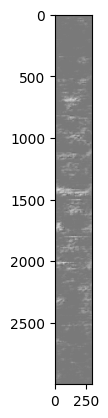

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image[0].numpy()[0])
# Visualize the generated sample
plt.imshow(generated_image[1][0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
decision = discriminator(generated_image[1], training = False)
print(decision[0])
print(decision[1])

tf.Tensor(
[[16.439272   0.         0.        24.372389   0.         0.
  17.303822   0.         0.        22.430462   0.         0.
  21.70952    0.         0.         4.7276025  0.         0.
   3.3553412  0.         0.        10.01422    0.         0.
   0.         0.         0.        10.8485565  0.         0.
   0.         1.8828373  0.         0.         0.         0.
   9.546215   0.         0.         0.         3.0591345  0.
   0.         0.         0.         0.         0.         0.
   0.         0.       ]], shape=(1, 50), dtype=float32)
tf.Tensor([[-5.4783177]], shape=(1, 1), dtype=float32)


In [ ]:
decision = discriminator(test_dataPINN[1].reshape(1, 3000, 300, 1), training = False)
print(decision[0])
print(decision[1])

tf.Tensor(
[[12.713192   0.         0.        18.620852   0.         0.
  18.550838   0.         0.        20.573313   0.         0.
  17.356075   0.         0.         7.191147   0.         0.
   4.826722   0.         0.        10.14402    0.         0.
   0.         0.         0.         7.092012   0.         0.
   0.         1.1094129  0.         0.         0.         0.
   8.19043    0.         0.         0.         2.1229074  0.
   1.4967268  0.         0.         0.         0.         0.
   0.         0.       ]], shape=(1, 50), dtype=float32)
tf.Tensor([[-7.556204]], shape=(1, 1), dtype=float32)


In [ ]:
decision = discriminator(test_dataPINN[0].reshape(1, 3000, 300, 1), training = False)
print(decision[0])
print(decision[1])

tf.Tensor(
[[14.938068    0.          0.         20.598043    0.          0.
  21.59232     0.          0.         22.009663    0.          0.
  17.030233    0.          0.          7.246203    0.          0.
   3.8999383   0.          0.         10.2681675   0.          0.
   0.          0.          0.          6.4601746   0.          0.
   0.          0.16768813  0.          0.          0.          0.
   9.225574    0.          0.          0.          1.6805661   0.
   2.1540601   0.          0.          0.          0.          0.
   0.          0.        ]], shape=(1, 50), dtype=float32)
tf.Tensor([[-7.9147463]], shape=(1, 1), dtype=float32)


In [ ]:
test_labels

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

In [ ]:
noise = tf.random.normal([21, noise_dim])

generated_images = generator(noise, training=False)

real_output = discriminator(test_dataPINN, training=False)
fake_output = discriminator(generated_images, training=False)

gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output, test_labels, test_dataPINN)

print(gen_loss, disc_loss)

ValueError: ignored

In [ ]:
fake_output

[<tf.Tensor: shape=(21, 50), dtype=float32, numpy=
 array([[14.502151,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [12.83755 ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [14.654665,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [15.856517,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [15.161327,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [15.947742,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]], dtype=float32)>,
 <tf.Tensor: shape=(21, 1), dtype=float32, numpy=
 array([[-5.6453133],
        [-1.0680608],
        [-4.639442 ],
        [-4.2370234],
        [-2.4512942],
        [-5.6100197],
        [-5.952506 ],
        [-4.1216426],
        [-0.8056987],
        [-3.0670705],
        [-6.9316053],
        [-2.0623865],
        [-3.2347775],
        [-3.3170161],
        [-6.4234185]

In [ ]:
real_output

[<tf.Tensor: shape=(21, 50), dtype=float32, numpy=
 array([[14.9380665,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [12.713193 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [13.717612 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [13.07106  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [13.581265 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [14.565805 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(21, 1), dtype=float32, numpy=
 array([[ -7.914747 ],
        [ -7.556207 ],
        [ -7.049925 ],
        [ -5.5441017],
        [ -5.756818 ],
        [ -4.6254716],
        [ -5.0242696],
        [ -6.5692515],
        [-10.230251 ],
        [ -5.1737437],
        [ -6.3584437],
        [ -2.6894271],
        [ -9.277

In [ ]:
test_labels

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

## Restore checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Results

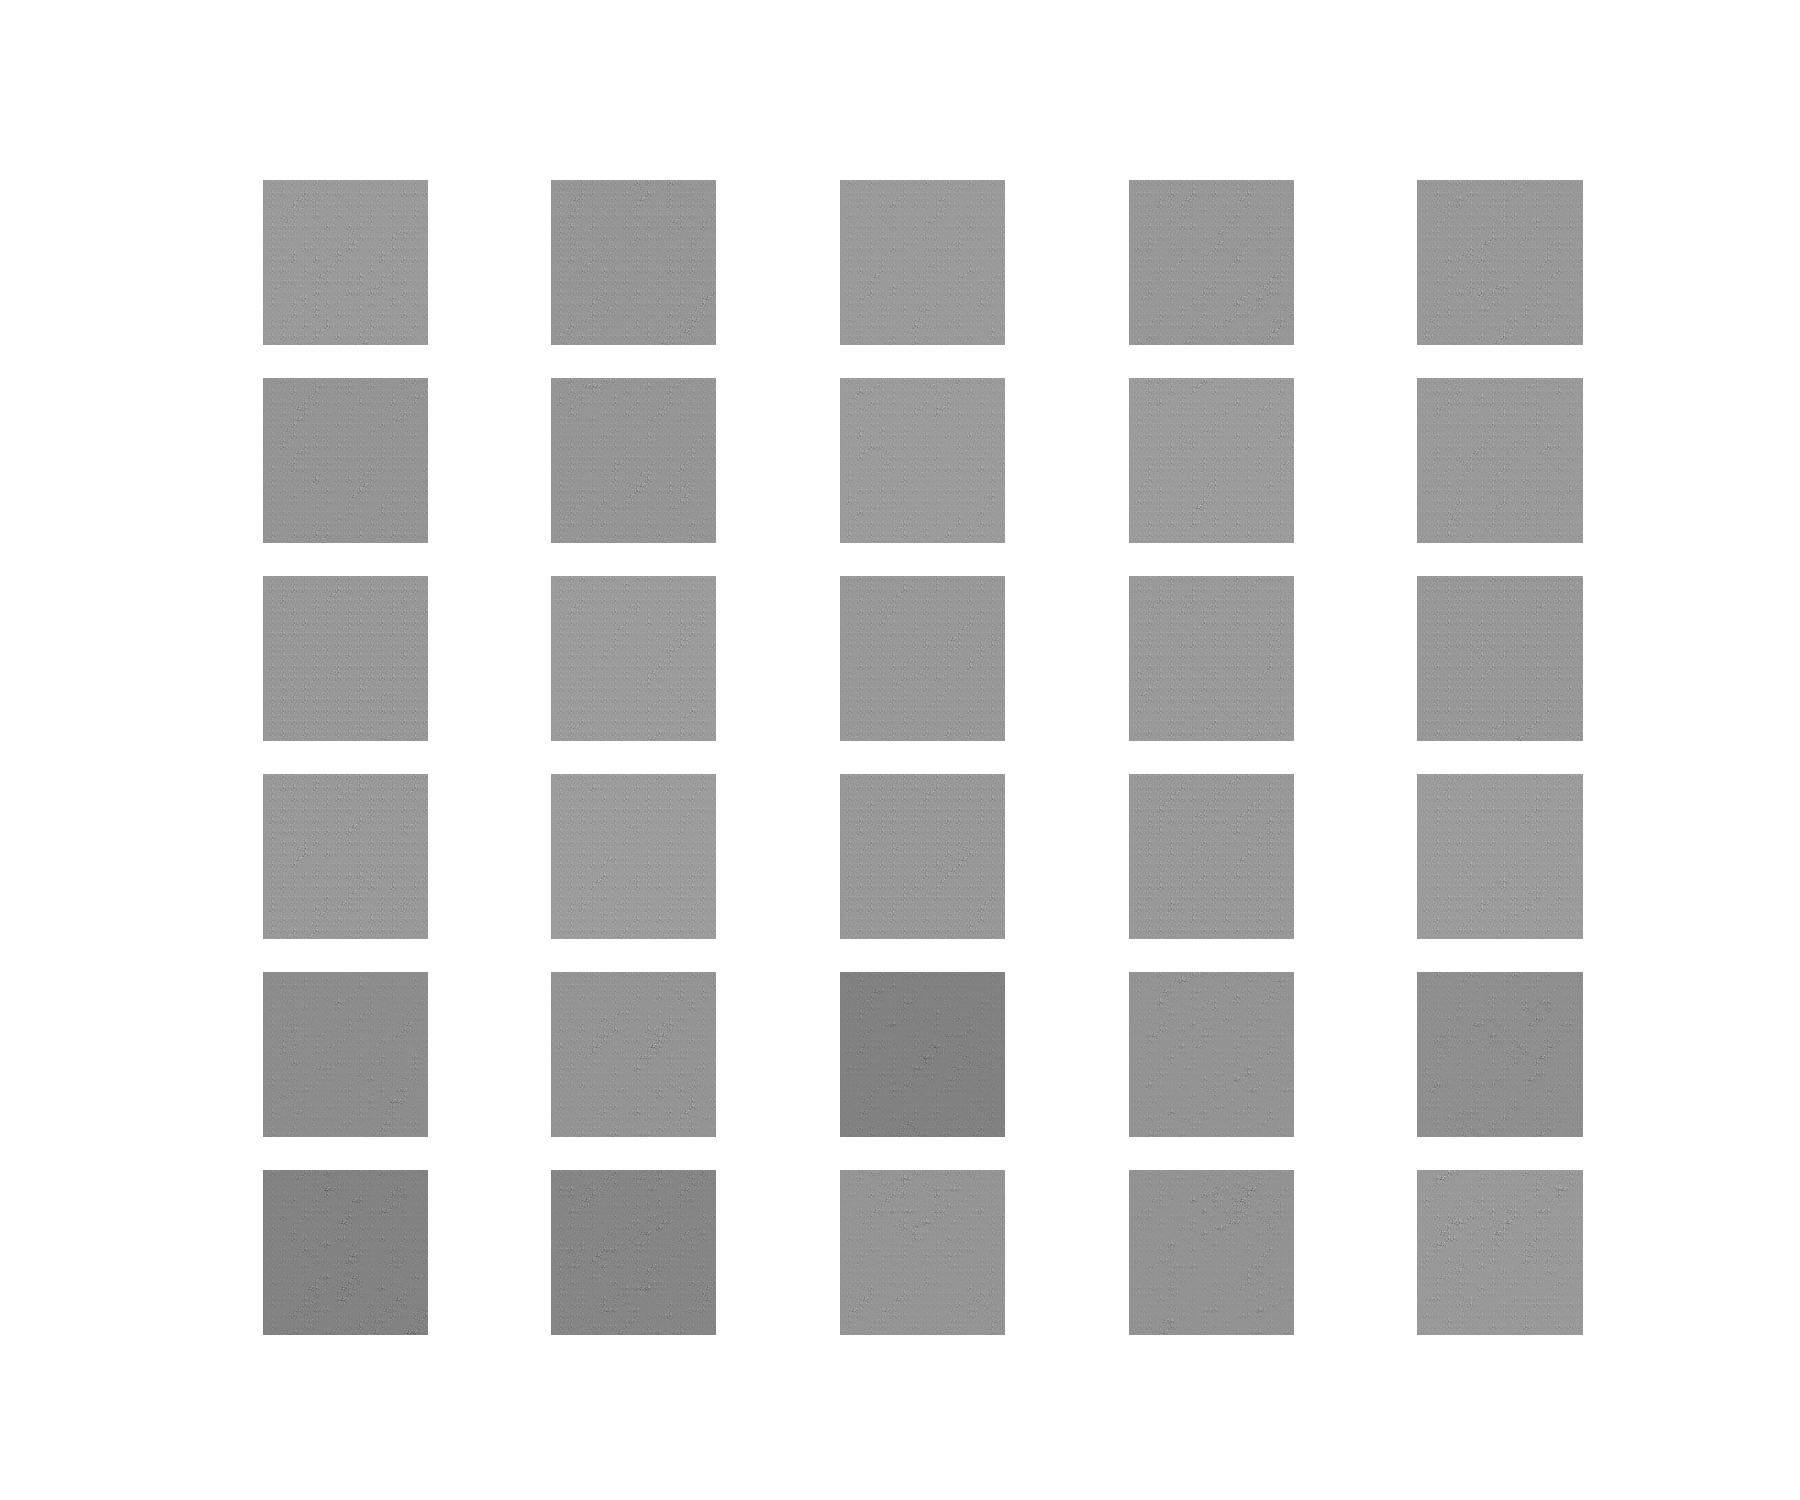

In [ ]:
# PIL is a library which may open different image file formats
import PIL
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(DIR+'image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = DIR+'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(DIR+'image*.png')
  filenames = sorted(filenames)
  i = 0
  for filename in filenames:
    i+=1
    print(filename, i)
    image = imageio.imread(filename)
    if i>200:
      writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)

display.Image(open(DIR+'dcgan.gif','rb').read())

gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0001.png 1
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0002.png 2
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0003.png 3


<ipython-input-77-3d4be5ebe932>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0004.png 4
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0005.png 5
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0006.png 6
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0007.png 7
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0008.png 8
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0009.png 9
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0010.png 10
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0011.png 11
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0012.png 12
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0013.png 13
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0014.png 14
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_at_epoch_0015.png 15
gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/image_

### Графики

In [ ]:
ac, f1, pr, re, d, g, d_cv, g_cv, d_plus_cv, g_plus_cv = [],[],[],[],[],[],[],[],[],[]
accuracy_, f1_, precision_, recall_, g_cv_for_graph, d_cv_for_graph = [],[],[],[],[],[]

with open('gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/test.txt', 'r') as file:
    for line in file:
        lol = line.split()
        ac.append(float(lol[2]))
        f1.append(float(lol[3]))
        pr.append(float(lol[4]))
        re.append(float(lol[5]))
        g.append(float(lol[6]))
        d.append(float(lol[7]))

        g_cv.append(float(lol[8]))
        d_cv.append(float(lol[9]))

        g_plus_cv.append(float(lol[6])+float(lol[8]))
        d_plus_cv.append(float(lol[7])+float(lol[9]))

        accuracy_.append(float(lol[3]))
        f1_.append(float(lol[4]))
        precision_.append(float(lol[5]))
        recall_.append(float(lol[6]))
        d_cv_for_graph.append(float(line.split()[2]))
print(ac[-43:], f1[-43:], pr[-43:], re[-43:], d[-43:], g[-43:], d_cv[-43:], g_cv[-43:], d_plus_cv[-43:], g_plus_cv[-43:], sep='\n')
print(len(ac[-43:]), len(d[-43:]), len(d_cv[-43:]))

[0.4838709677419355, 0.4838709677419355, 0.45161290322580644, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.41935483870967744, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

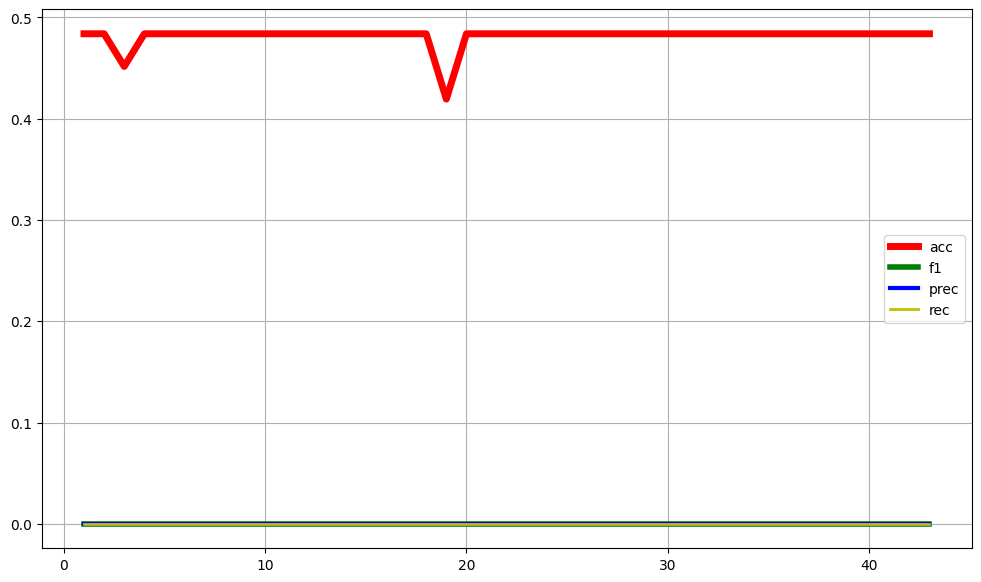

In [ ]:
x = range(1, len(d[-43:])+1)
y1 = ac[-43:]
y2 = f1[-43:]
y3 = pr[-43:]
y4 = re[-43:]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="f1", mec='g', lw=4, mew=2, ms=10)
plt.plot(x, y3, '-b', label="prec", lw=3, mec='b', mew=2, ms=10)
plt.plot(x, y4, '-y', label="rec", mec='y', lw=2, mew=2, ms=10)
plt.legend()
plt.grid(True)

In [ ]:
x = range(1, len(d[-43:])+1)
y1 = d[-43:]
y2 = g[-43:]
plt.figure(figsize=(12, 7))
plt.title('Loss (BinaryCrossentropy)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

NameError: ignored

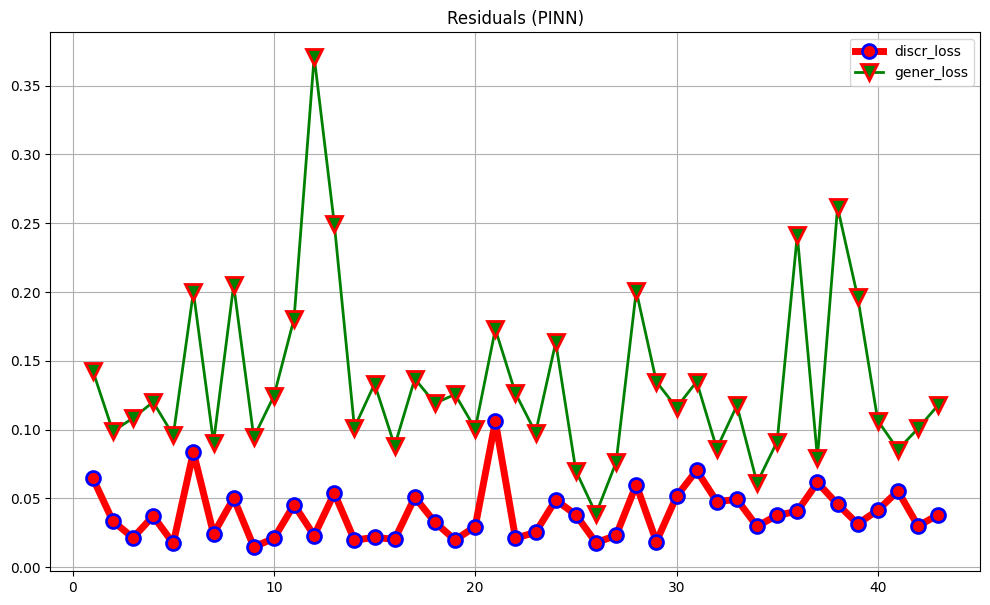

In [ ]:
x = range(1, len(d[-43:])+1)
y1 = d_cv[-43:]
y2 = g_cv[-43:]
plt.figure(figsize=(12, 7))
plt.title('Residuals (PINN)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

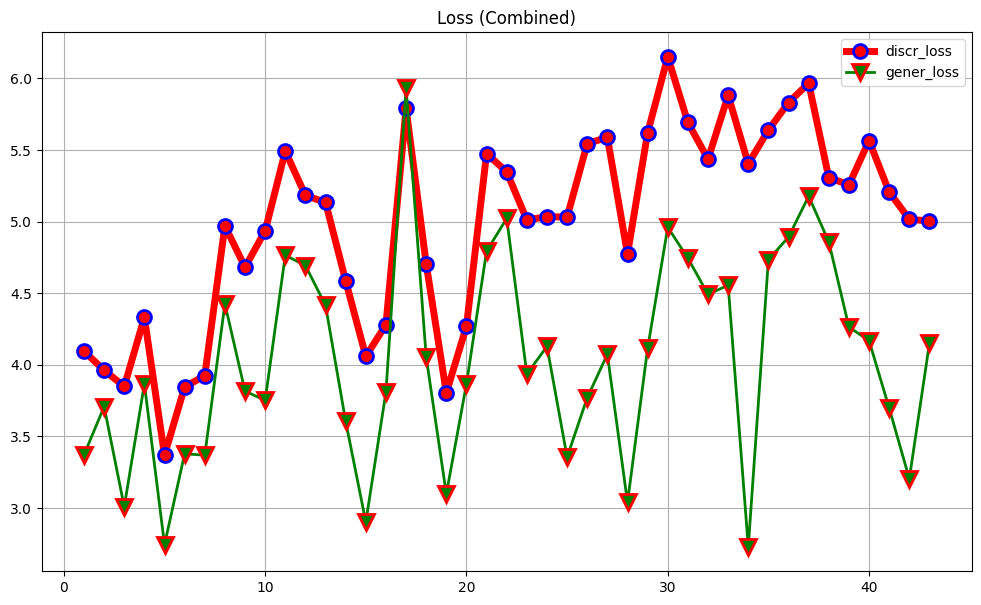

In [ ]:
x = range(1, len(d[-43:])+1)
y1 = d_plus_cv[-43:]
y2 = g_plus_cv[-43:]
plt.figure(figsize=(12, 7))
plt.title('Loss (Combined)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [ ]:
ac, f1, pr, re, d, g, d_cv, g_cv, d_plus_cv, g_plus_cv = [],[],[],[],[],[],[],[],[],[]

with open('gdrive/MyDrive/Colab_Notebooks/Images/GAN_with_Pinn/test.txt', 'r') as file:
    for line in file:
        lol = line.split()
        ac.append(float(lol[2]))
        f1.append(float(lol[3]))
        pr.append(float(lol[4]))
        re.append(float(lol[5]))
        g.append(float(lol[6]))
        d.append(float(lol[7]))

        g_cv.append(float(lol[8]))
        d_cv.append(float(lol[9]))

        g_plus_cv.append(float(lol[6])+float(lol[8]))
        d_plus_cv.append(float(lol[7])+float(lol[9]))


        accuracy_.append(float(lol[3]))
        f1_.append(float(lol[4]))
        precision_.append(float(lol[5]))
        recall_.append(float(lol[6]))
        g_cv_for_graph.append(float(line.split()[1]))
        d_cv_for_graph.append(float(line.split()[2]))
print(ac[20:], f1[20:], pr[20:], re[20:], d[20:], g[20:], d_cv[20:], g_cv[20:], d_plus_cv[20:], g_plus_cv[20:], sep='\n')
print(len(ac[20:]), len(d), len(d_cv))

[0.7096774193548387, 0.7096774193548387, 0.7419354838709677, 0.6774193548387096, 0.7419354838709677, 0.7419354838709677, 0.7096774193548387, 0.6774193548387096, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387, 0.7419354838709677, 0.8064516129032258, 0.8387096774193549, 0.9032258064516129, 0.7741935483870968, 0.7419354838709677, 0.7096774193548387, 0.6774193548387096, 0.7096774193548387, 0.7419354838709677, 0.5806451612903226, 0.5806451612903226, 0.6774193548387096, 0.6451612903225806, 0.6774193548387096, 0.6129032258064516, 0.6129032258064516, 0.7096774193548387, 0.6129032258064516, 0.7096774193548387, 0.7096774193548387, 0.5806451612903226, 0.7096774193548387, 0.5483870967741935, 0.6451612903225806, 0.7419354838709677, 0.6451612903225806, 0.6451612903225806, 0.4838709677419355, 0.7096774193548387, 0.8064516129032258, 0.7741935483870968, 0.7741935483870968, 0.4838709677419355, 0.7096774193548387, 0.8387096774193549, 0.8387096774193549, 0.8387096774193549, 0.8387096774193549,

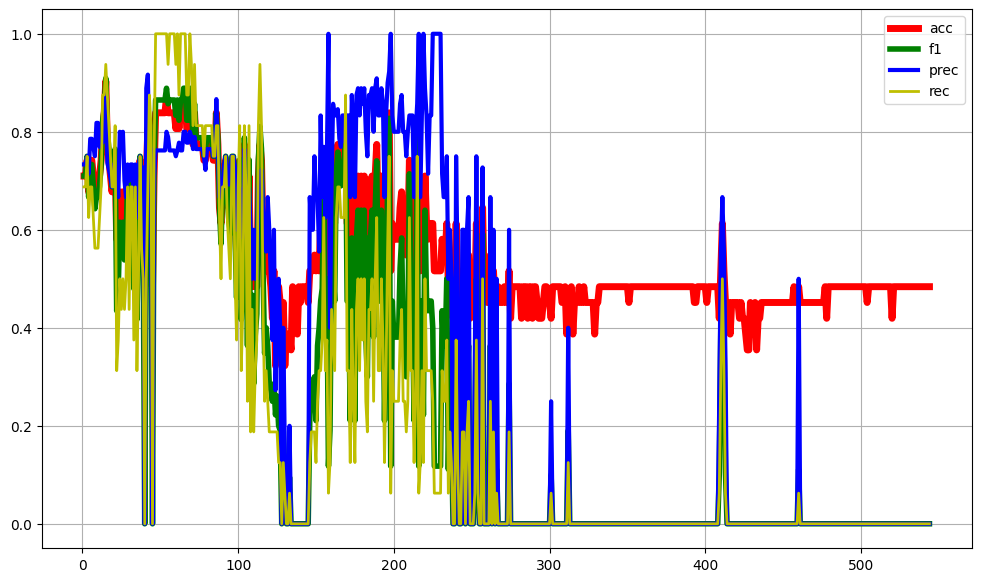

In [ ]:
x = range(1, len(d[20:])+1)
y1 = ac[20:]
y2 = f1[20:]
y3 = pr[20:]
y4 = re[20:]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="f1", mec='g', lw=4, mew=2, ms=10)
plt.plot(x, y3, '-b', label="prec", lw=3, mec='b', mew=2, ms=10)
plt.plot(x, y4, '-y', label="rec", mec='y', lw=2, mew=2, ms=10)
plt.legend()
plt.grid(True)

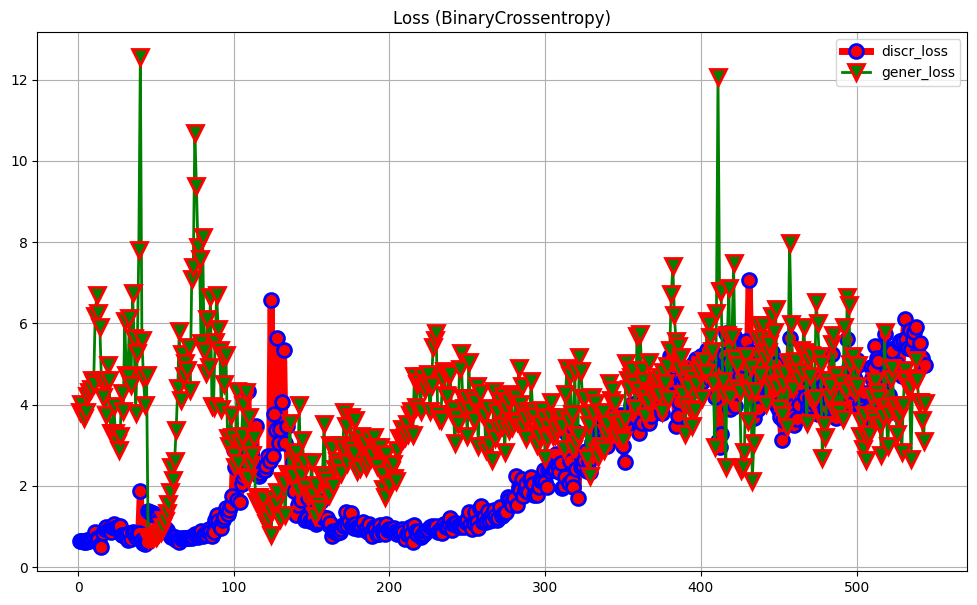

In [ ]:
x = range(1, len(d[20:])+1)
y1 = d[20:]
y2 = g[20:]
plt.figure(figsize=(12, 7))
plt.title('Loss (BinaryCrossentropy)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

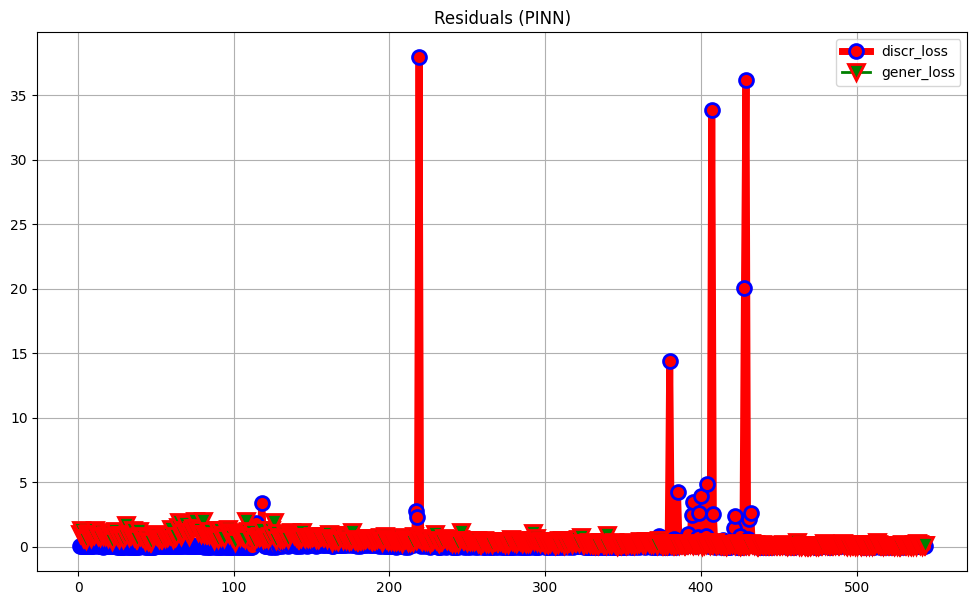

In [ ]:
x = range(1, len(d[20:])+1)
y1 = d_cv[20:]
y2 = g_cv[20:]
plt.figure(figsize=(12, 7))
plt.title('Residuals (PINN)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

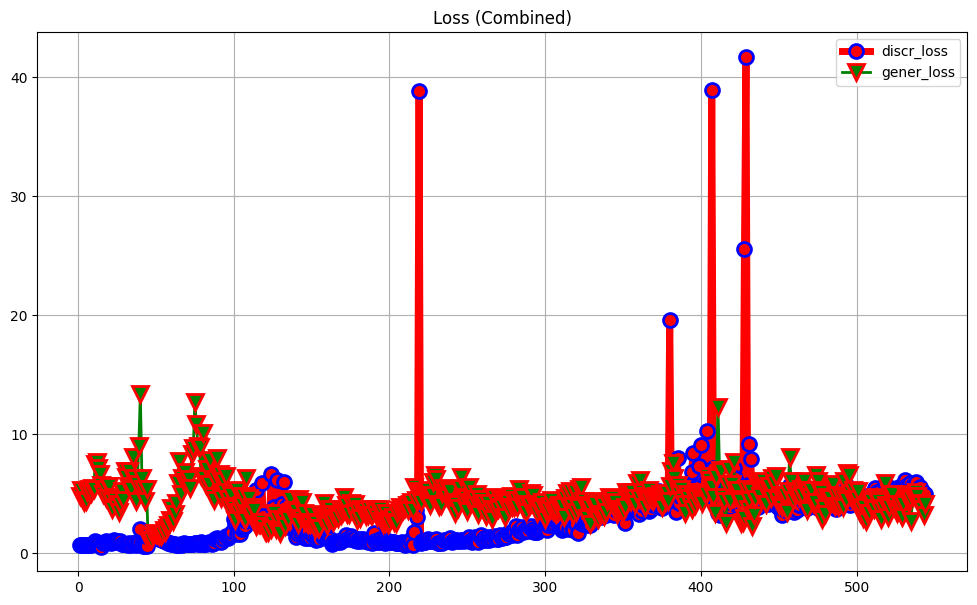

In [ ]:
x = range(1, len(d[20:])+1)
y1 = d_plus_cv[20:]
y2 = g_plus_cv[20:]
plt.figure(figsize=(12, 7))
plt.title('Loss (Combined)')
plt.plot(x, y1, 'o-r', label="discr_loss", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

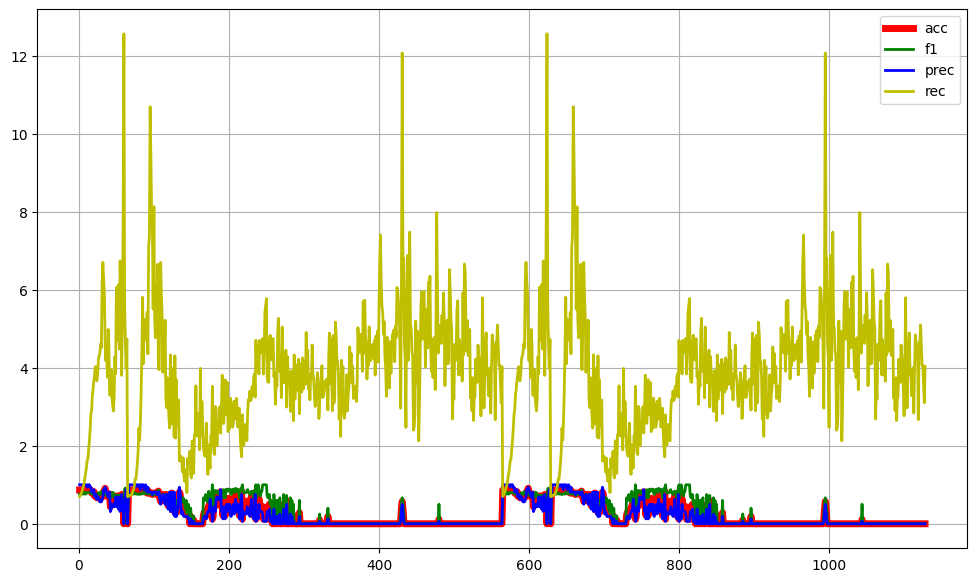

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = accuracy_
y2 = f1_
y3 = precision_
y4 = recall_
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="f1", mec='g', lw=2, mew=2, ms=10)
plt.plot(x, y3, '-b', label="prec", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y4, '-y', label="rec", mec='y', lw=2, mew=2, ms=10)
plt.legend()
plt.grid(True)

ValueError: ignored

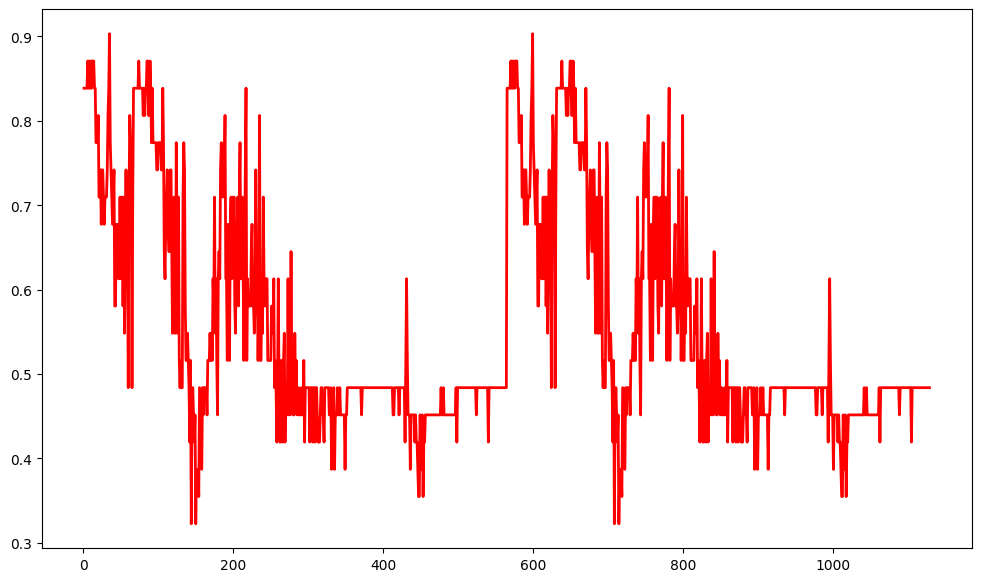

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = d_cv_for_graph
y2 = g_cv_for_graph
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="discr_loss", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

ValueError: ignored

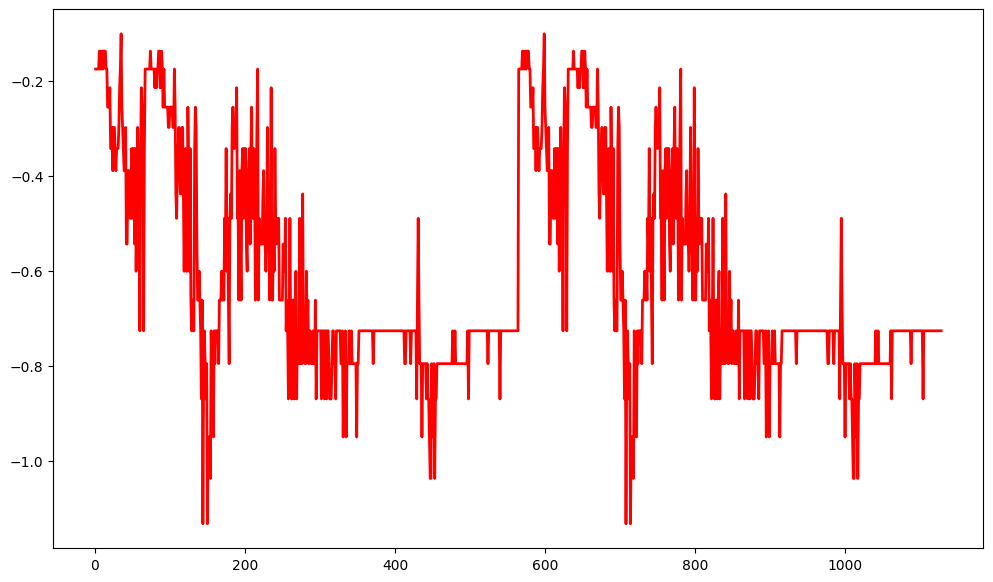

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = np.log(d_cv_for_graph)
y2 = np.log(g_cv_for_graph)
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="discr_loss", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

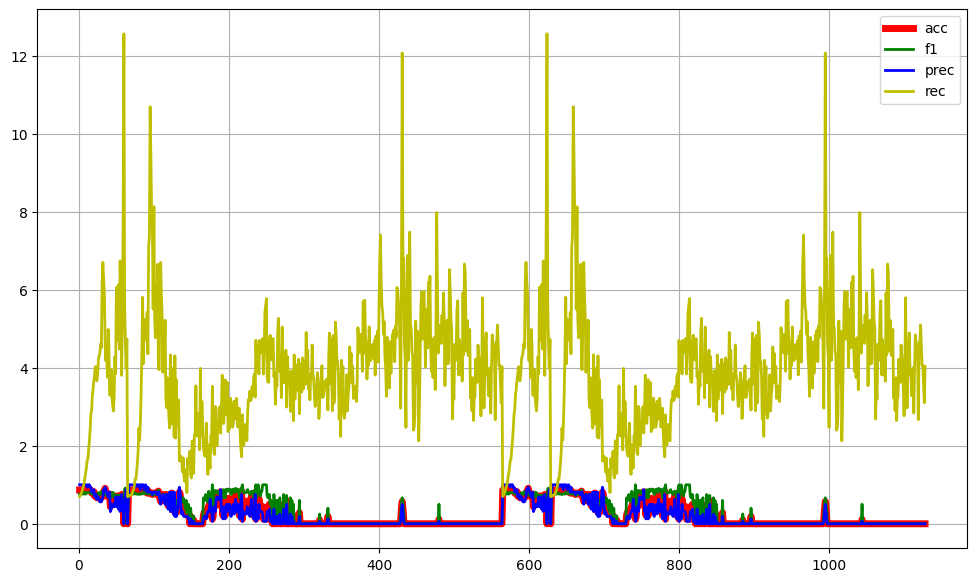

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = accuracy_
y2 = f1_
y3 = precision_
y4 = recall_
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="f1", mec='g', lw=2, mew=2, ms=10)
plt.plot(x, y3, '-b', label="prec", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y4, '-y', label="rec", mec='y', lw=2, mew=2, ms=10)
plt.legend()
plt.grid(True)

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = d_cv_for_graph
y2 = g_cv_for_graph
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="discr_loss", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

NameError: ignored

In [ ]:
x = range(1, len(d_cv_for_graph)+1)
y1 = np.log(d_cv_for_graph)
y2 = np.log(g_cv_for_graph)
plt.figure(figsize=(12, 7))
plt.plot(x, y1, '-r', label="discr_loss", lw=2, mec='b', mew=2, ms=10)
plt.plot(x, y2, '-g', label="gener_loss", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)